# Label Type Detection
Train a model that can predict the label captured in a representitive image: phase, nuclear, fluorescent cytoplasm.

In [1]:
import os
import errno
import functools

import numpy as np
import tensorflow as tf

import deepcell

/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


## Generate all label dataset
Download HeLa data for nuclear, brightfield and fluorescent cytoplasm

In [ ]:
from deepcell.datasets import hela_s3, phase, cytoplasm

nuc_train, nuc_test = hela_s3.load_data()
brtfld_train, brtfld_test = phase.HeLa_S3.load_data()
flr_train, flr_test = cytoplasm.hela_s3.load_data()

In [5]:
# Reshape each dataset to conform to the minimum size of 216
from deepcell.utils.data_utils import reshape_matrix

RESHAPE_SIZE = 216

for train, test in zip([nuc_train, brtfld_train, flr_train], 
                       [nuc_test, brtfld_test, flr_test]):
    train['X'], train['y'] = reshape_matrix(train['X'], train['y'], RESHAPE_SIZE)
    test['X'], test['y'] = reshape_matrix(test['X'], test['y'], RESHAPE_SIZE)

Reshaped feature data from (6480, 216, 256, 1) to (6480, 216, 216, 1)
Reshaped training data from (6480, 216, 256, 1) to (6480, 216, 216, 1)
Reshaped feature data from (720, 216, 256, 1) to (720, 216, 216, 1)
Reshaped training data from (720, 216, 256, 1) to (720, 216, 216, 1)
Reshaped feature data from (576, 512, 512, 1) to (5184, 216, 216, 1)
Reshaped training data from (576, 512, 512, 1) to (5184, 216, 216, 1)
Reshaped feature data from (64, 512, 512, 1) to (576, 216, 216, 1)
Reshaped training data from (64, 512, 512, 1) to (576, 216, 216, 1)
Reshaped feature data from (576, 512, 512, 1) to (5184, 216, 216, 1)
Reshaped training data from (576, 512, 512, 1) to (5184, 216, 216, 1)
Reshaped feature data from (64, 512, 512, 1) to (576, 216, 216, 1)
Reshaped training data from (64, 512, 512, 1) to (576, 216, 216, 1)


Y labeling scheme

- Nuclear = 0
- Phase = 1
- Fluorescent Cytoplasm = 2

In [6]:
def make_y(batch,i):
    y = np.zeros((batch,3))
    y[:,i] = 1
    return y

In [8]:
# Stack up our data as train and test
X_train = np.vstack([nuc_train['X'], brtfld_train['X'], flr_train['X']])
y_train = np.vstack([make_y(nuc_train['y'].shape[0],0), 
                     make_y(brtfld_train['y'].shape[0],1),
                     make_y(flr_train['y'].shape[0],2)])

X_test = np.vstack([nuc_test['X'], brtfld_test['X'], flr_test['X']])
y_test = np.vstack([make_y(nuc_test['y'].shape[0],0), 
                     make_y(brtfld_test['y'].shape[0],1),
                     make_y(flr_test['y'].shape[0],2)])

In [ ]:
# Load the data into a tensors as X and y
X = np.vstack([X_train, X_test])
y = np.vstack([y_train, y_test])

In [ ]:
# Set up filepath constants

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.getcwd() #os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# filename to write combined data
filename = 'HeLa-mixed-labels-binary.npz'

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# the path to the data file is currently required for `train_model_()` functions
np.savez(DATA_FILE, X=X, y=y)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

## Define data generator

In [5]:
from tensorflow.python.keras.preprocessing.image import Iterator
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import array_to_img
from tensorflow.python.keras import backend as K
import numpy as np

In [6]:
class ImageFullyConvIterator(Iterator):
    
    def __init__(self,
                 train_dict,
                 image_data_generator,
                 batch_size=1,
                 skip=None,
                 shuffle=False,
                 transform=None,
                 transform_kwargs={},
                 seed=None,
                 data_format='channels_last',
                 save_to_dir=None,
                 save_prefix='',
                 save_format='png'):
        X, y = train_dict['X'], train_dict['y']
        self.x = np.asarray(X, dtype=K.floatx())

        if self.x.ndim != 4:
            raise ValueError('Input data in `ImageFullyConvIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)

        self.y = y
    
        self.channel_axis = 3 if data_format == 'channels_last' else 1
        self.skip = skip
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(ImageFullyConvIterator, self).__init__(
            self.x.shape[0], batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros(tuple([len(index_array)] + list(self.x.shape)[1:]))
        batch_y = np.zeros(tuple([len(index_array)] + list(self.y.shape)[1:]))

        for i, j in enumerate(index_array):
            x = self.x[j]
            y = self.y[j]

            x = self.image_data_generator.random_transform(x.astype(K.floatx()))
            x = self.image_data_generator.standardize(x)

            batch_x[i] = x
            batch_y[i] = y

        if self.save_to_dir:
            for i, j in enumerate(index_array):
                if self.data_format == 'channels_first':
                    img_x = np.expand_dims(batch_x[i, 0, ...], 0)
                else:
                    img_x = np.expand_dims(batch_x[i, ..., 0], -1)
                img = array_to_img(img_x, self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e4),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))

                if self.y is not None:
                    # Save argmax of y batch
                    img_y = np.argmax(batch_y[i], axis=self.channel_axis - 1)
                    img_y = np.expand_dims(img_y, axis=self.channel_axis - 1)
                    img = array_to_img(img_y, self.data_format, scale=True)
                    fname = 'y_{prefix}_{index}_{hash}.{format}'.format(
                        prefix=self.save_prefix,
                        index=j,
                        hash=np.random.randint(1e4),
                        format=self.save_format)
                    img.save(os.path.join(self.save_to_dir, fname))

        if self.y is None:
            return batch_x

        if self.skip is not None:
            batch_y = [batch_y] * (self.skip + 1)
        return batch_x, batch_y

    def next(self):
        """For python 2.x. Returns the next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)


class ImageFullyConvDataGenerator(ImageDataGenerator):
    
    def flow(self,
             train_dict,
             batch_size=1,
             skip=None,
             transform=None,
             transform_kwargs={},
             shuffle=True,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png'):
        """Generates batches of augmented/normalized data with given arrays.

        Args:
            train_dict: dictionary of X and y tensors. Both should be rank 4.
            batch_size: int (default: 1).
            shuffle: boolean (default: True).
            seed: int (default: None).
            save_to_dir: None or str (default: None).
                This allows you to optionally specify a directory
                to which to save the augmented pictures being generated
                (useful for visualizing what you are doing).
            save_prefix: str (default: `''`). Prefix to use for filenames of
                saved pictures (only relevant if `save_to_dir` is set).
            save_format: one of "png", "jpeg". Default: "png".
                (only relevant if `save_to_dir` is set)

        Returns:
            An Iterator yielding tuples of `(x, y)` where `x` is a numpy array
            of image data and `y` is a numpy array of labels of the same shape.
        """
        return ImageFullyConvIterator(
            train_dict,
            self,
            batch_size=batch_size,
            transform=transform,
            transform_kwargs=transform_kwargs,
            skip=skip,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)

    def random_transform(self, x, y=None, seed=None):
        """Applies a random transformation to an image.

        Args:
            x: 3D tensor or list of 3D tensors,
                single image.
            y: 3D tensor or list of 3D tensors,
                label mask(s) for `x`, optional.
            seed: Random seed.

        Returns:
            A randomly transformed version of the input (same shape).
            If `y` is passed, it is transformed if necessary and returned.
        """
        params = self.get_random_transform(x.shape, seed)

        if isinstance(x, list):
            x = [self.apply_transform(x_i, params) for x_i in x]
        else:
            x = self.apply_transform(x, params)

        if y is None:
            return x

        # Nullify the transforms that don't affect `y`
        params['brightness'] = None
        params['channel_shift_intensity'] = None
        _interpolation_order = self.interpolation_order
        self.interpolation_order = 0

        if isinstance(y, list):
            y = [self.apply_transform(y_i, params) for y_i in y]
        else:
            y = self.apply_transform(y, params)

        self.interpolation_order = _interpolation_order
        return x, y

## Define model

In [8]:
from tensorflow.python.keras.layers import Input, AveragePooling2D, Flatten, Activation
from deepcell.layers import ImageNormalization2D, TensorProduct
from tensorflow.python.keras.models import Sequential, Model
from deepcell.utils.backbone_utils import get_backbone

def label_model(input_shape=(None, None, 1),
                inputs=None,
                backbone='VGG16',
                use_imagenet=True,
                required_channels=3,
                norm_method='whole_image',
                pooling=None):
    if inputs is None:
        inputs = Input(shape=input_shape)
    
    norm = ImageNormalization2D(norm_method=norm_method)(inputs)
    fixed_inputs = TensorProduct(required_channels)(norm)
    
    # force the input shape
    fixed_input_shape = list(input_shape)
    fixed_input_shape[-1] = required_channels
    fixed_input_shape = tuple(fixed_input_shape)

    model_kwargs = {
        'include_top': False,
        'weights': None,
        'input_shape': fixed_input_shape,
        'pooling': pooling
    }
    
    backbone = get_backbone(backbone, fixed_inputs, use_imagenet=use_imagenet, return_dict=False, **model_kwargs)
    
    backbone_inputs = backbone.inputs
    backbone_outputs = backbone.outputs[0]
        
    new_model_inputs = backbone_inputs
    x = AveragePooling2D(4)(backbone_outputs)
    x = TensorProduct(256)(x)
    x = TensorProduct(3)(x)
    x = Flatten()(x)
    new_model_outputs = Activation('softmax')(x)
    
    new_model = Model(inputs=new_model_inputs, outputs=new_model_outputs)
    
    return new_model
    

In [10]:
trial_model = label_model(input_shape=(216,216,1))
trial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 216, 216, 1)       0         
_________________________________________________________________
image_normalization2d (Image (None, 216, 216, 1)       3721      
_________________________________________________________________
tensor_product (TensorProduc (None, 216, 216, 3)       6         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 216, 216, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 216, 216, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 108, 108, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 108, 108, 128)     73856     
__________

In [11]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler
from deepcell import losses

def loss_fxn(y_true, y_pred):
    return (losses.weighted_categorical_crossentropy(
            y_true, y_pred, n_classes=2))

n_epoch = 20  # Number of training epochs
lr = 1e-3
optimizer = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=lr, decay=0.99)
batch_size = 4

trial_model.compile(optimizer, loss=loss_fxn)

In [13]:
model_path = '/notebooks/data/LabelDetection-helaMultiLabel.h5'

## Train model

In [15]:
# Initialize data generators for training
gen = ImageFullyConvDataGenerator(
            rotation_range=180,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=(0.5, 2))

val_dict = {
    'X':X_test,
    'y':y_test
}

train_dict = {
    'X':X_train,
    'y':y_train
}

train_data = gen1.flow(train_dict)
val_data = gen1.flow(val_dict)

In [ ]:
from tensorflow.python.keras import callbacks

trial_model.fit_generator(train_data, 
                          steps_per_epoch=train_data.y.shape[0]//batch_size,
                          epochs=n_epoch,
                          validation_data=val_data,
                            validation_steps=val_data.y.shape[0] // batch_size,
                          callbacks=[
                            callbacks.LearningRateScheduler(lr_sched),
                            callbacks.ModelCheckpoint(
                                model_path, monitor='val_loss', verbose=1,
                                save_best_only=True)
                        ])

Epoch 1/20
4210/4212 [============================>.] - ETA: 0s - loss: 0.0339
Epoch 00001: val_loss improved from inf to 0.04373, saving model to /notebooks/data/LabelDetection-helaMultiLabel.h5
4212/4212 [==============================] - 115s 27ms/step - loss: 0.0339 - val_loss: 0.0437
Epoch 2/20
4211/4212 [============================>.] - ETA: 0s - loss: 0.0387
Epoch 00002: val_loss did not improve from 0.04373
4212/4212 [==============================] - 113s 27ms/step - loss: 0.0387 - val_loss: 0.0524
Epoch 3/20
4210/4212 [============================>.] - ETA: 0s - loss: 0.0370
Epoch 00003: val_loss did not improve from 0.04373
4212/4212 [==============================] - 113s 27ms/step - loss: 0.0370 - val_loss: 0.0445
Epoch 4/20
4211/4212 [============================>.] - ETA: 0s - loss: 0.0412
Epoch 00004: val_loss improved from 0.04373 to 0.03538, saving model to /notebooks/data/LabelDetection-helaMultiLabel.h5
4212/4212 [==============================] - 113s 27ms/step - 

## Test model predictions

array([[188,   0,   2],
       [  0, 157,   5],
       [  2,   1, 145]])

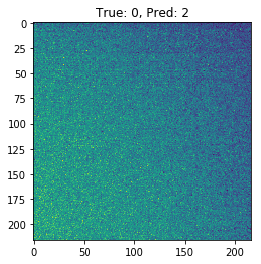

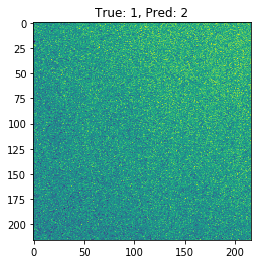

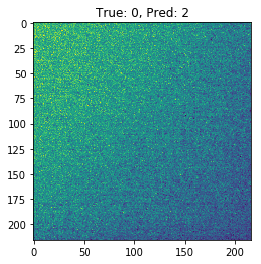

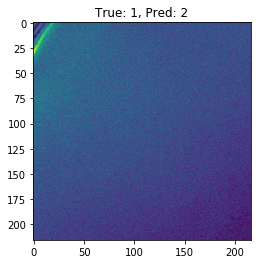

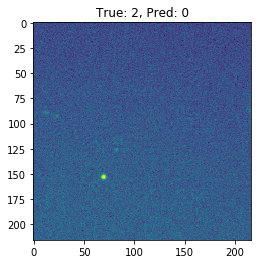

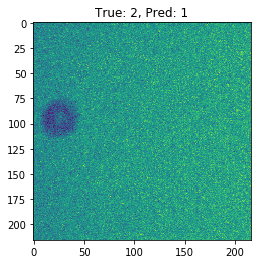

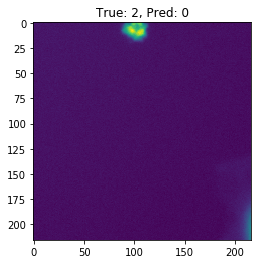

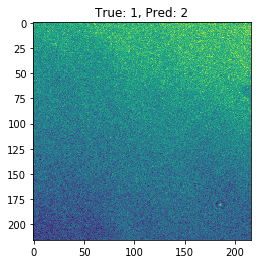

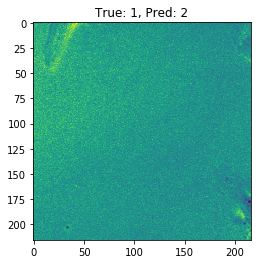

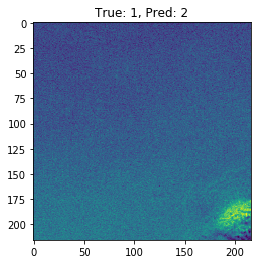

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Ltrue, Lpred = [],[]
for i in range(500):
    X,y = val_data.next()
    true = np.where(y==1)[-1][0]
    p = trial_model.predict(X)
    pred = np.where(p == p.max())[-1][0]
    
    Ltrue.append(true)
    Lpred.append(pred)
    
    if true != pred:
        fig,ax = plt.subplots()
        ax.imshow(X[0,:,:,0])
        ax.set_title('True: {}, Pred: {}'.format(true,pred))
        
confusion_matrix(Ltrue,Lpred)